# Preinstalling Necessary Packages:

!pip install pandas
!pip install xlsxwriter
!pip install matplotlib
!pip install numpy
!pip install scikit-learn
!pip install seaborn
!pip install statsmodels

 # Import Necessary Libraries

In [130]:
import pandas as pd
from pathlib import Path
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_regression
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Function Declarations

In [131]:
def check_dup_rows():
    # Check for duplicate rows based on the entire 'datetime' column
    duplicate_rows = train_set[train_set.duplicated(subset=['datetime'], keep=False)]

    if duplicate_rows.empty:
        print("No duplicate rows found.")
    else:
        print("Duplicate rows found:")
        print(duplicate_rows)

In [132]:
#Function to fill all the NAN values in the dataset using interpolation
def fill_null_with_linear_interpolation(df, column_to_fill):
    df[column_to_fill] = df[column_to_fill].interpolate(method='linear')
    return df

This function fill_null_with_linear_interpolation interpolates missing values in the specified column of a DataFrame using linear interpolation.

In [133]:
#Function to calculate wind energy from wind speed
def calculate_wind_energy(wind_speed, sealevelpressure):
     # Assuming standard sea-level temperature is 288.15 K (15°C)
    temperature_k = 288.15
    # Specific gas constant for dry air, R = 287.05 J/(kg·K)
    R = 287.05
    #The turbine has a 24 m diameter, which means the radius is 12 m. 
    #Thus, the swept area of the turbine is: (pi)r2 = 3.14159(122) = 452.4 m2
    cross_sectional_area = 452.4 #m^2 
    # Convert sea-level pressure from millibars (mb) to Pascals (Pa)
    sea_pressure_pa = sealevelpressure * 100   
    # Calculate air density (kg/m^3)
    air_density = sea_pressure_pa / (R * temperature_k)
    #assuming 116 windmills in number
    num_of_mills = 116 
    wind_energy = 0.5 * air_density * cross_sectional_area * num_of_mills * (wind_speed**3)
    wind_energy_mwh = wind_energy/1000000
    return round(wind_energy_mwh, 2)

The calculate_wind_energy function calculates the estimated wind energy output (in megawatt-hours, MWh) based on the provided wind speed. It assumes 116 windmills, each with a turbine diameter of 24 meters, resulting in a swept area of 452.4 square meters, and utilizes the formula for wind power.

Reference for wind energy calculation: https://www.e-education.psu.edu/emsc297/node/649#:~:text=Thus%2C%20the%20power%20available%20to,variable%20input%20is%20wind%20speed.

Reference for number of wind mills:https://www.rampionoffshore.com/#:~:text=The%20wind%20farm%20comprises%20116,coast%20in%20the%20English%20Channel.

In [134]:
#Function to calculate solar energy from solar radiation
def calculate_solar_energy(solar_radiation):
    # Assuming surface area of 20 square meters and efficiency of 20%
    surface_area = 20  # in square meters
    efficiency = 0.20  # 20% efficiency
    num_of_pannels = 369
    solar_energy = solar_radiation * surface_area * efficiency*num_of_pannels
    solar_energy_mwh = solar_energy/1000000
    return round(solar_energy_mwh, 2)

The function calculate_solar_energy estimates the solar energy output (in MWh) based on the provided solar radiation, assuming a surface area of 20 square meters and an efficiency of 20% for each of the 369 solar panels.

Reference for solar energy calculation: https://www.saurenergy.com/solar-energy-blog/here-is-how-you-can-calculate-the-annual-solar-energy-output-of-a-photovoltaic-system

Reference for number of solar panels: https://www.brighton-hove.gov.uk/news/2023/hundreds-council-homes-switch-solar-power

# Loading the Data

In [135]:
warnings.simplefilter(action='ignore', category=FutureWarning)

# Please change the directory to the location of the folder with the data
directory = r'weatherdata_for_students'

# Create an empty list to store DataFrames and file names
dfs = []
file_names = []

# Loop through file names and load each CSV file
for i in range(1, 129):
    # Generate file name with leading zeros
    file_name = f'brighton_{i:03}.csv'
    
    # Construct the full file path
    file_path = os.path.join(directory, file_name)
    
    # Check if the file exists before loading
    if os.path.exists(file_path):
        try:
            # Load the CSV file into a DataFrame
            df = pd.read_csv(file_path, header=None)  # Read without header

            # Check if the first row contains numerical indices
            if df.iloc[0].astype(str).str.isnumeric().all():
                # Use the second row as the header
                df.columns = df.iloc[1]

                # Drop the first two rows
                df = df.drop([0, 1])
            else:
                # Use the first row as the header
                df.columns = df.iloc[0]

                # Drop the first row
                df = df.drop(0)

            # Append the DataFrame to the list
            dfs.append(df)
            
            # Append the file name to the list
            file_names.append(file_name)
        except Exception as e:
            print(f"Error loading file {file_name}: {e}")
    else:
        print(f"File not found: {file_name}")
        
# Concatenate the list of DataFrames into one
result_df = pd.concat(dfs, ignore_index=True)
df.head()

1,datetime,temp,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,solarradiation,solarenergy,uvindex
2,2023-11-29T00:00:00,1.8,0.4,90.39,0.0,0.0,NaN,0.0,0.0,10.2,269.0,1008.4,32.5,0,0.0,0.0
3,2023-11-29T01:00:00,2.3,0.6,88.65,0.0,0.0,NaN,0.0,0.0,8.9,273.0,1008.0,91.6,0,0.0,0.0
4,2023-11-29T02:00:00,3.1,1.2,86.78,0.0,0.0,NaN,0.0,0.0,7.2,276.0,1007.6,100.0,0,0.0,0.0
5,2023-11-29T03:00:00,3.8,1.6,85.11,0.0,0.0,NaN,0.0,0.0,3.0,28.0,1007.0,94.1,0,0.0,0.0
6,2023-11-29T04:00:00,4.0,1.9,86.33,0.0,0.0,NaN,0.0,0.0,4.6,356.0,1006.6,100.0,0,0.0,0.0


We have an hourly time series

# Data Splitting

In [136]:
# Extract the 'datetime' column
time_column = "datetime"

# Sort the DataFrame by the time column
result_df_sorted = result_df.sort_values(by=time_column)

import pandas as pd

# Convert 'datetime' column to datetime format
result_df['datetime'] = pd.to_datetime(result_df['datetime'])

# Extract year from the datetime column and assign it to a new column
result_df['year'] = pd.to_datetime(result_df['datetime']).dt.year
train_set = result_df

The data set is divided into 3 sets - Train, Validation and Test in a ratio of 80:10:10

# Data Processing on Train Set

In [137]:
# Drop the 'solarenergy' column as we will recalculate it using given features and assumptions
train_set.drop(columns=['solarenergy'], inplace=True)
#Convert Data Types for processing
train_set['datetime'] = pd.to_datetime(train_set['datetime'])
train_set[['temp', 'dew', 'humidity', 'precip', 'precipprob', 'snow', 'snowdepth', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'solarradiation', 'uvindex']] = train_set[['temp', 'dew', 'humidity', 'precip', 'precipprob', 'snow', 'snowdepth', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'solarradiation', 'uvindex']].apply(pd.to_numeric, errors='coerce')
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122844 entries, 0 to 122843
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   datetime          122844 non-null  datetime64[ns]
 1   temp              122590 non-null  float64       
 2   dew               122568 non-null  float64       
 3   humidity          122575 non-null  float64       
 4   precip            122565 non-null  float64       
 5   precipprob        122558 non-null  float64       
 6   preciptype        11277 non-null   object        
 7   snow              89810 non-null   float64       
 8   snowdepth         89279 non-null   float64       
 9   windspeed         122583 non-null  float64       
 10  winddir           122567 non-null  float64       
 11  sealevelpressure  122319 non-null  float64       
 12  cloudcover        122556 non-null  float64       
 13  solarradiation    122514 non-null  float64       
 14  uvin

In [138]:
#Check Null/NAN after datatype conversion
train_set.isnull().sum()

datetime                 0
temp                   254
dew                    276
humidity               269
precip                 279
precipprob             286
preciptype          111567
snow                 33034
snowdepth            33565
windspeed              261
winddir                277
sealevelpressure       525
cloudcover             288
solarradiation         330
uvindex                358
year                     0
dtype: int64

Our data set has NAN values

In [139]:
#check the duplicate rows in the train data set
check_dup_rows()

Duplicate rows found:
                  datetime  temp   dew  humidity  precip  precipprob  \
7272   2010-10-31 01:00:00  12.4  10.6     88.49   0.000         0.0   
7273   2010-10-31 01:00:00  12.4  10.3     87.33   0.000         0.0   
16008  2011-10-30 01:00:00  14.2  12.3     88.87   0.000         0.0   
16009  2011-10-30 01:00:00  14.4  12.5     88.08   0.000         0.0   
24744  2012-10-28 01:00:00   2.6   0.9     88.68   0.112       100.0   
24745  2012-10-28 01:00:00   2.5   0.7     87.94   0.000         0.0   
33480  2013-10-27 01:00:00  15.0  13.5     90.29   3.592       100.0   
33481  2013-10-27 01:00:00  14.1  13.0     93.01   0.000         0.0   
42216  2014-10-26 01:00:00  12.9   9.1     77.71   0.000         0.0   
42217  2014-10-26 01:00:00  13.4   8.7     73.15   0.000         0.0   
50952  2015-10-25 01:00:00   7.0   5.5     90.03   1.031       100.0   
50953  2015-10-25 01:00:00   6.4   5.0     90.58   0.000         0.0   
59856  2016-10-30 01:00:00   8.5   8.1    

Our data set has duplicate rows

In [140]:
# Fill in the duplicate rows with mean of the group
train_set = train_set.groupby('datetime').mean().reset_index()
#Verfiy if duplicate rows are removed
check_dup_rows()


No duplicate rows found.


In [141]:
#Check Missing Rows
start_date = train_set['datetime'].iloc[0]
end_date = train_set['datetime'].iloc[-1]
complete_date_range = pd.date_range(start=start_date, end=end_date, freq='H')

missing_rows = complete_date_range[~complete_date_range.isin(train_set['datetime'])]

print("Dates with missing rows:")
print(missing_rows)

Dates with missing rows:
DatetimeIndex(['2010-03-28 01:00:00', '2011-03-27 01:00:00',
               '2012-03-25 01:00:00', '2013-03-31 01:00:00',
               '2014-03-30 01:00:00', '2015-03-29 01:00:00',
               '2016-03-27 01:00:00', '2017-03-26 01:00:00',
               '2018-03-25 01:00:00', '2019-03-31 01:00:00',
               '2020-03-29 01:00:00', '2021-03-28 01:00:00',
               '2022-03-27 01:00:00', '2023-03-26 01:00:00'],
              dtype='datetime64[ns]', freq=None)


Missing Dates Indicates that the rows are missing due to daylight saving time changes.
We will fill it using Linear Interpolation as the chunk size is not big.

In [142]:
#Fill in missing dates
# Create an empty DataFrame to hold the new rows
new_rows = pd.DataFrame(columns=train_set.columns)
# Loop through the missing dates and add them one by one into the DataFrame
for missing_date in missing_rows:
    new_row = pd.DataFrame({'datetime': [missing_date]})
    new_rows = pd.concat([new_rows, new_row], ignore_index=True)

# Append the new rows to the DataFrame
train_set = pd.concat([train_set, new_rows], ignore_index=True)
train_set.sort_values(by='datetime', inplace=True)

In [143]:
#Linear Interpolation to fill NAN
columns_to_fill = ['temp', 'dew', 'humidity', 'precip', 'precipprob', 'snow', 'snowdepth', 'windspeed','winddir', 'sealevelpressure', 'cloudcover', 'solarradiation', 'uvindex']

# Iterate through each column and fill missing values
for column in columns_to_fill:
    train_set = fill_null_with_linear_interpolation(train_set, column)


In [144]:
# Conversion factor from kilometers per hour to meters per second
conversion_factor_kph_to_mps = 0.277778

# Convert 'windspeed' from miles per hour to kilometers per hour
train_set['windspeed_ms'] = train_set['windspeed']*conversion_factor_kph_to_mps


Reference for conversion factor : https://www.gigacalculator.com/converters/convert-kmph-to-mps.php

In [145]:
train_set.head()

,datetime,temp,dew,humidity,precip,precipprob,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,solarradiation,uvindex,year,windspeed_ms
0,2010-01-01 00:00:00,1.9,-0.5,84.25,0.417,100.0,0.0,0.0,19.4,11.0,999.9,62.2,0.0,0.0,2010.0,5.388893
1,2010-01-01 01:00:00,1.9,-0.5,83.90,0.000,0.0,0.0,0.0,21.8,19.0,999.8,22.4,0.0,0.0,2010.0,6.055560
2,2010-01-01 02:00:00,1.4,-0.7,85.76,0.000,0.0,0.0,0.0,17.7,10.0,1000.0,38.0,0.0,0.0,2010.0,4.916671
3,2010-01-01 03:00:00,1.4,-0.7,85.69,0.000,0.0,0.0,0.0,18.0,11.0,1000.2,66.7,0.0,0.0,2010.0,5.000004
4,2010-01-01 04:00:00,1.3,-0.8,85.72,0.000,0.0,0.0,0.0,17.4,10.0,1000.5,62.8,0.0,0.0,2010.0,4.833337


In [146]:
train_set.isnull().sum()

datetime             0
temp                 0
dew                  0
humidity             0
precip               0
precipprob           0
snow                 0
snowdepth            0
windspeed            0
winddir              0
sealevelpressure     0
cloudcover           0
solarradiation       0
uvindex              0
year                14
windspeed_ms         0
dtype: int64

In [147]:
#Calculate wind energy in MW by using windspeed
train_set['windenergyMW'] = train_set.apply(lambda row: calculate_wind_energy(row['windspeed_ms'], row['sealevelpressure']), axis=1)

In [148]:
#Calculate solar energy in MW by using solarradiation
train_set['solarenergyMW'] = train_set['solarradiation'].apply(calculate_solar_energy)

In [149]:
train_set.head()

,datetime,temp,dew,humidity,precip,precipprob,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,solarradiation,uvindex,year,windspeed_ms,windenergyMW,solarenergyMW
0,2010-01-01 00:00:00,1.9,-0.5,84.25,0.417,100.0,0.0,0.0,19.4,11.0,999.9,62.2,0.0,0.0,2010.0,5.388893,4.96,0.0
1,2010-01-01 01:00:00,1.9,-0.5,83.90,0.000,0.0,0.0,0.0,21.8,19.0,999.8,22.4,0.0,0.0,2010.0,6.055560,7.04,0.0
2,2010-01-01 02:00:00,1.4,-0.7,85.76,0.000,0.0,0.0,0.0,17.7,10.0,1000.0,38.0,0.0,0.0,2010.0,4.916671,3.77,0.0
3,2010-01-01 03:00:00,1.4,-0.7,85.69,0.000,0.0,0.0,0.0,18.0,11.0,1000.2,66.7,0.0,0.0,2010.0,5.000004,3.97,0.0
4,2010-01-01 04:00:00,1.3,-0.8,85.72,0.000,0.0,0.0,0.0,17.4,10.0,1000.5,62.8,0.0,0.0,2010.0,4.833337,3.58,0.0


# Plots for Visualization of the Data

In [150]:
train_set['datetime_copy'] = train_set['datetime']  # Retain as Duplicate column

# Convert 'datetime' column to datetime
train_set['datetime'] = pd.to_datetime(train_set['datetime'])

# Set 'datetime' column as the index
train_set.set_index('datetime', inplace=True)

# Extract year and month
train_set['year'] = train_set.index.year
train_set['month'] = train_set.index.strftime('%b')


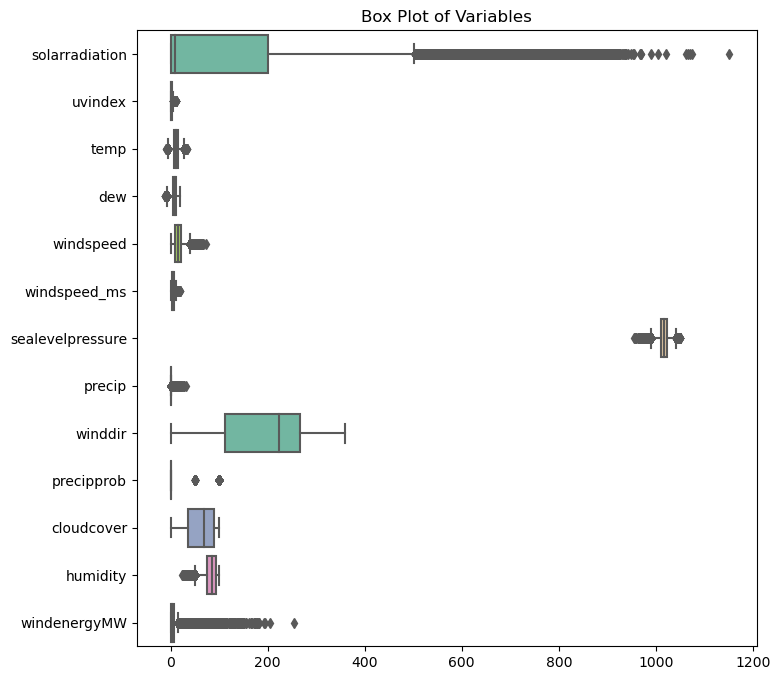

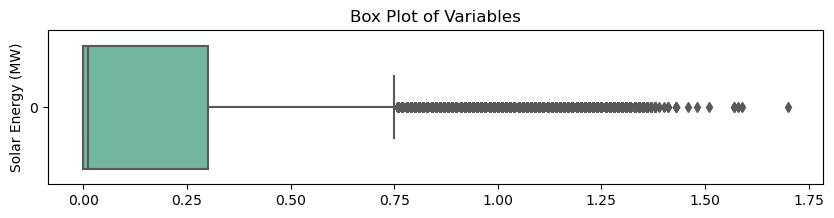

In [151]:
# Box plot columns
data = train_set[['solarradiation', 'uvindex', 'temp', 'dew', 'windspeed','windspeed_ms', 'sealevelpressure', 'precip', 'winddir', 'precipprob', 'cloudcover', 'humidity','windenergyMW']]
# Check if the dataframe is not empty
if not data.empty:
    # Create a box plot using seaborn
    plt.figure(figsize=(8, 8))
    sns.boxplot(data=data, orient='h', palette='Set2')
    plt.title('Box Plot of Variables')
    plt.show()
    
    # Create a box plot using seaborn
    plt.figure(figsize=(10, 2))
    sns.boxplot(data=train_set['solarenergyMW'], orient='h', palette='Set2')
    plt.title('Box Plot of Variables')
    plt.ylabel('Solar Energy (MW)')
    plt.show()
else:
    print("The dataframe is empty.")

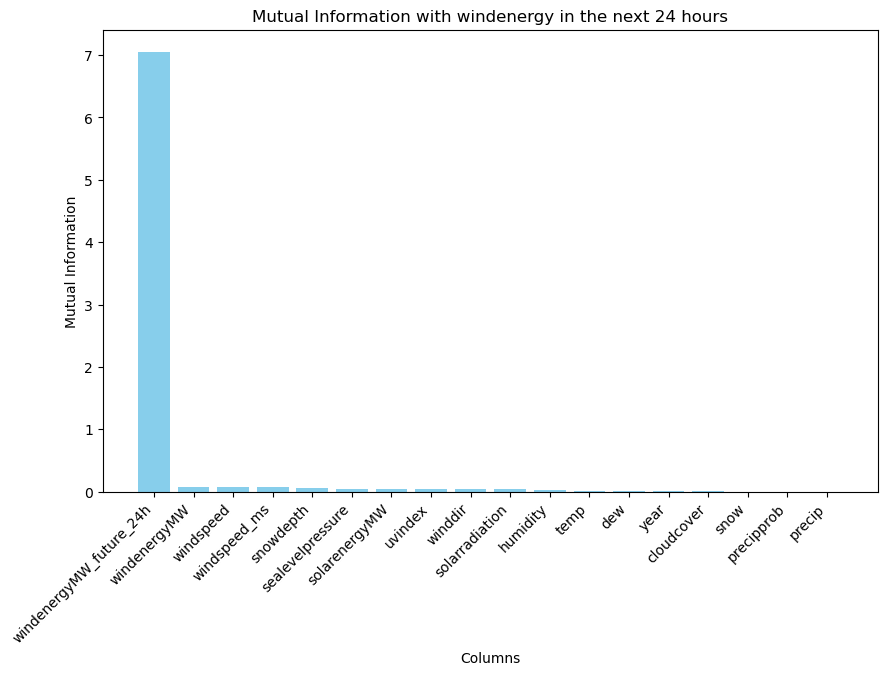

In [152]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression

# Shifting target variable by 24 rows to represent windenergy in the next 24 hours
train_set['windenergyMW_future_24h'] = train_set['windenergyMW'].shift(24)

# Drop rows with NaN values introduced by the shift operation
train_set.dropna(inplace=True)

# Selecting numerical columns
numerical_cols = train_set.select_dtypes(include='number').columns

# Calculating mutual information for each numerical column with windenergy in the next 24 hours
mutual_info_values = []
for col in numerical_cols:
    mutual_info = mutual_info_regression(train_set[[col]], train_set['windenergyMW_future_24h'])
    mutual_info_values.append(mutual_info[0])

# Creating a DataFrame with mutual information values
mutual_info_df = pd.DataFrame({'Column': numerical_cols, 'Mutual_Info': mutual_info_values})

# Sorting DataFrame by mutual information values
mutual_info_df = mutual_info_df.sort_values(by='Mutual_Info', ascending=False)

# Plotting the mutual information values
plt.figure(figsize=(10, 6))
plt.bar(mutual_info_df['Column'], mutual_info_df['Mutual_Info'], color='skyblue')
plt.title('Mutual Information with windenergy in the next 24 hours')
plt.xlabel('Columns')
plt.ylabel('Mutual Information')
plt.xticks(rotation=45, ha='right')
plt.show()


This mutual information plot tells us the relation of windenergy feature with other features.We get an idea on what features to focus on more.

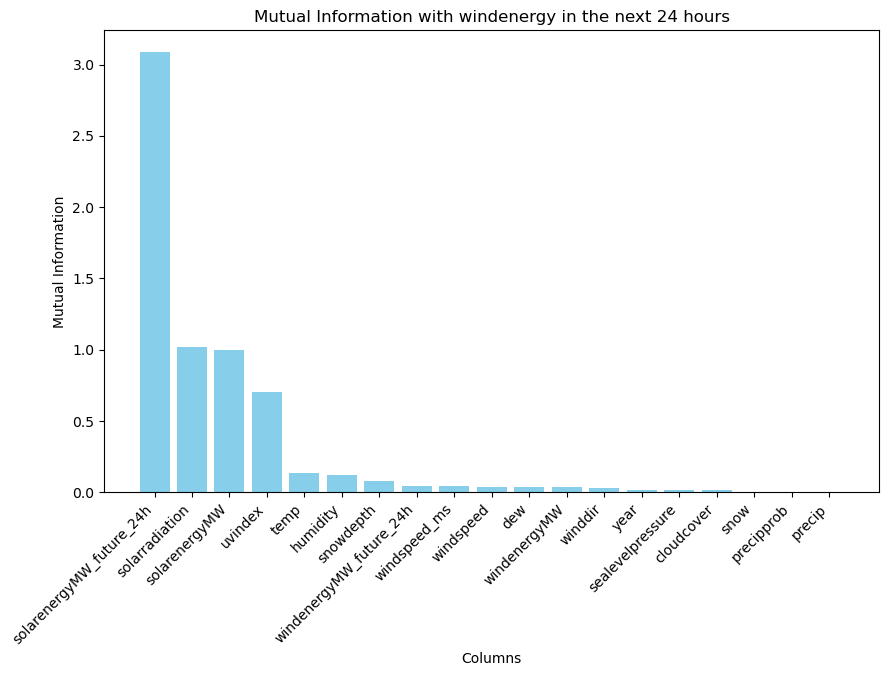

In [153]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression

# Shifting target variable by 24 rows to represent windenergy in the next 24 hours
train_set['solarenergyMW_future_24h'] = train_set['solarenergyMW'].shift(24)

# Drop rows with NaN values introduced by the shift operation
train_set.dropna(inplace=True)

# Selecting numerical columns
numerical_cols = train_set.select_dtypes(include='number').columns

# Calculating mutual information for each numerical column with windenergy in the next 24 hours
mutual_info_values = []
for col in numerical_cols:
    mutual_info = mutual_info_regression(train_set[[col]], train_set['solarenergyMW_future_24h'])
    mutual_info_values.append(mutual_info[0])

# Creating a DataFrame with mutual information values
mutual_info_df = pd.DataFrame({'Column': numerical_cols, 'Mutual_Info': mutual_info_values})

# Sorting DataFrame by mutual information values
mutual_info_df = mutual_info_df.sort_values(by='Mutual_Info', ascending=False)

# Plotting the mutual information values
plt.figure(figsize=(10, 6))
plt.bar(mutual_info_df['Column'], mutual_info_df['Mutual_Info'], color='skyblue')
plt.title('Mutual Information with windenergy in the next 24 hours')
plt.xlabel('Columns')
plt.ylabel('Mutual Information')
plt.xticks(rotation=45, ha='right')
plt.show()


This mutual information plot tells us the relation of solarenergy feature with other features. We get an idea on what features to focus on more.

# Plots for Solar Energy

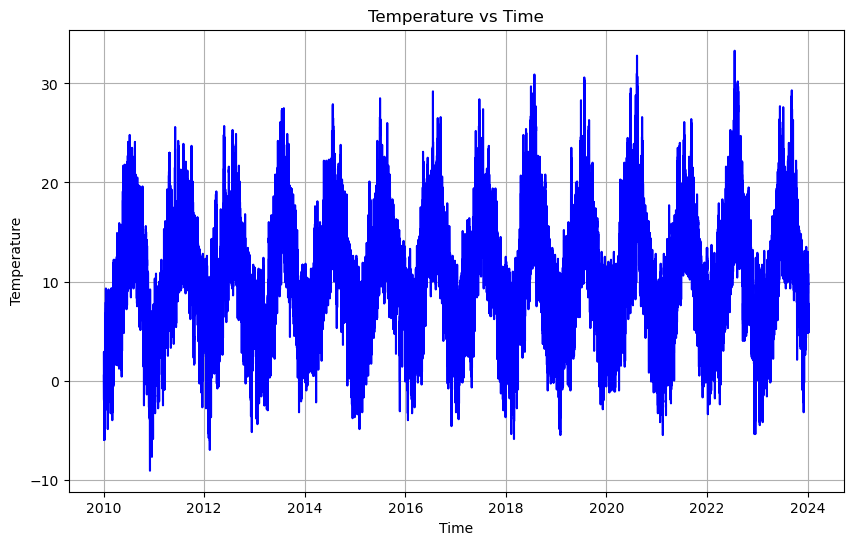

In [154]:
# Plotting temperature vs time
plt.figure(figsize=(10, 6))
plt.plot(train_set.index, train_set['temp'], color='blue', linestyle='-')
plt.title('Temperature vs Time')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.grid(True)
plt.show()

We have clear periodicity every year. In the plot we see 11 cycles (which correspond to our 11 years of data).

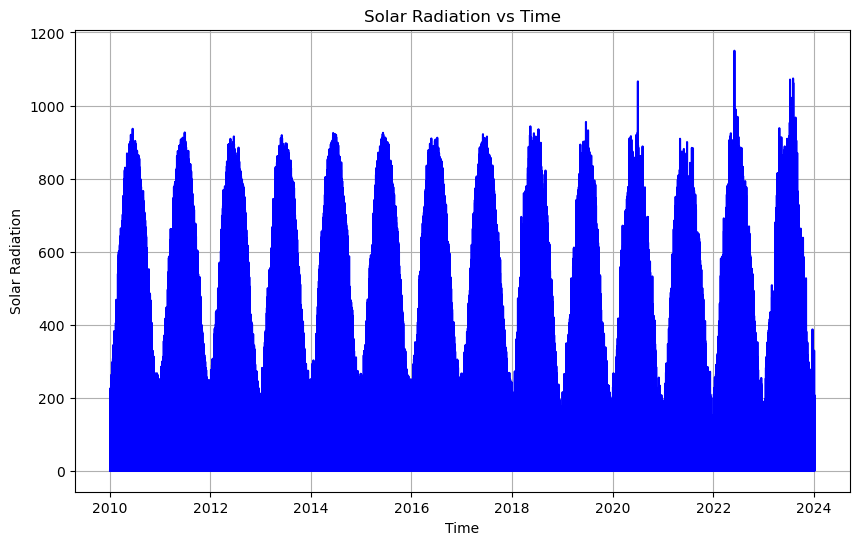

In [155]:
# Plotting Solar Radiation vs Time
plt.figure(figsize=(10, 6))
plt.plot(train_set.index, train_set['solarradiation'], color='blue', linestyle='-')
plt.title('Solar Radiation vs Time')
plt.xlabel('Time')
plt.ylabel('Solar Radiation')
plt.grid(True)
plt.show()

The plot shows seasonality with clear cycles, consistency over time and is inline with the tempeature plot

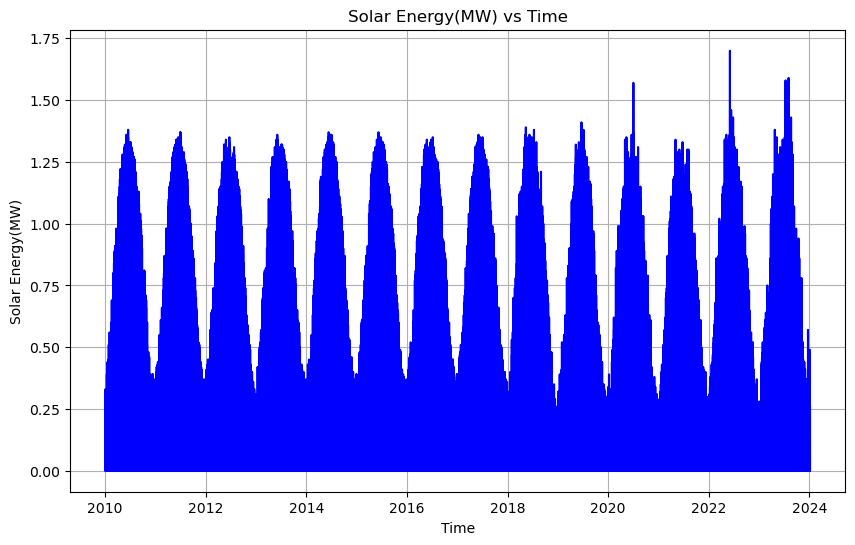

In [156]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_set.index, train_set['solarenergyMW'], color='blue', linestyle='-')
plt.title('Solar Energy(MW) vs Time')
plt.xlabel('Time')
plt.ylabel('Solar Energy(MW)')
plt.grid(True)
plt.show()

The plot shows seasonality with clear cycles, consistency over time and is inline with the tempeature and solar radiation plot

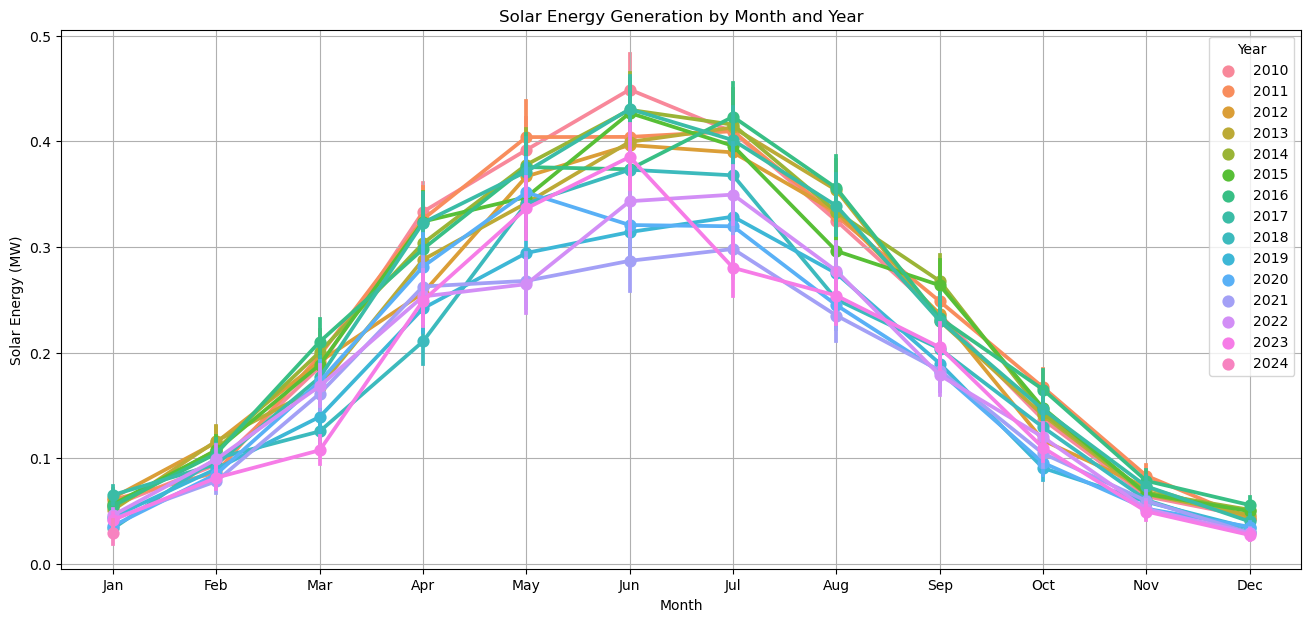

In [157]:
# Stacked line plot for solar energy
plt.figure(figsize=(16,7))
sns.pointplot(x='month', y='solarenergyMW', hue='year', data=train_set)
plt.title('Solar Energy Generation by Month and Year')
plt.xlabel('Month')
plt.ylabel('Solar Energy (MW)')
plt.legend(title='Year')
plt.grid(True)
plt.show()

The seasonal plot shows us a clear trend of high solar energy in the summer season and low solar energy during the winters

# Plots for Wind Energy

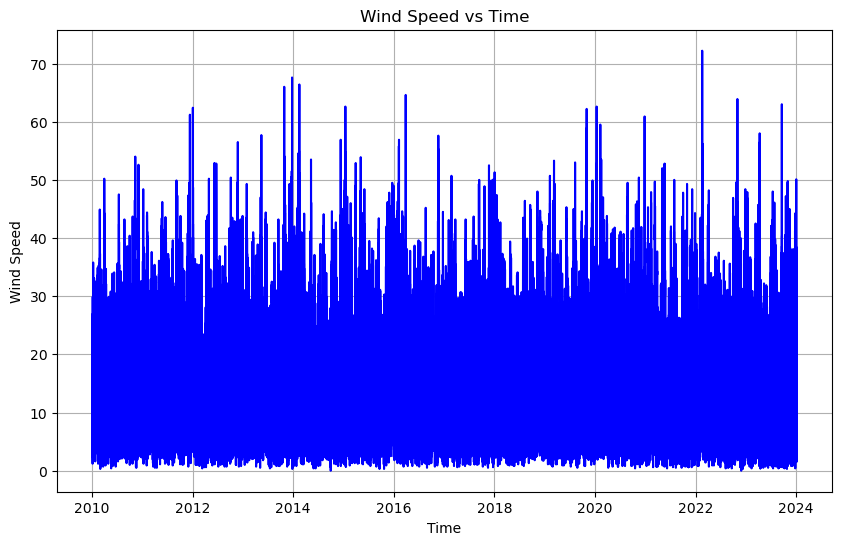

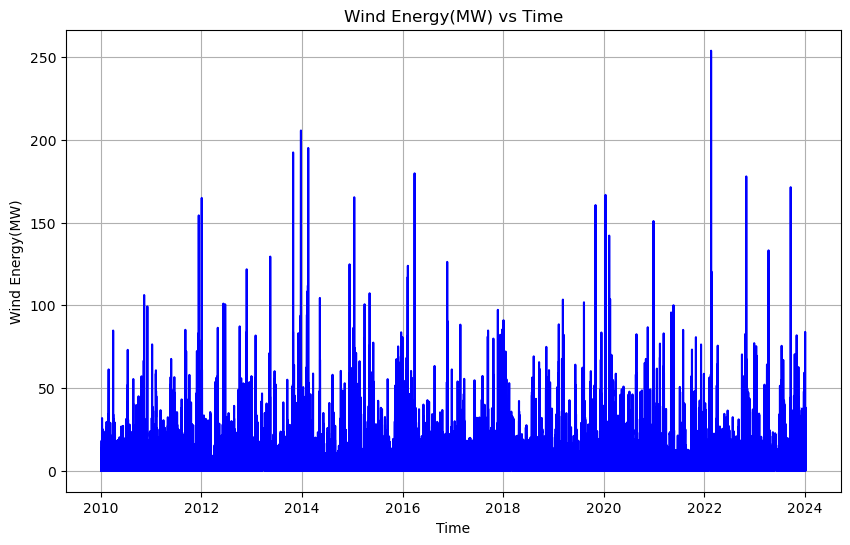

In [158]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_set.index, train_set['windspeed'], color='blue', linestyle='-')
plt.title('Wind Speed vs Time')
plt.xlabel('Time')
plt.ylabel('Wind Speed')
plt.grid(True)
plt.show()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_set.index, train_set['windenergyMW'], color='blue', linestyle='-')
plt.title('Wind Energy(MW) vs Time')
plt.xlabel('Time')
plt.ylabel('Wind Energy(MW)')
plt.grid(True)
plt.show()



The plots show that there are no long term trends in windspeed and wind energy.

The lack of a long-term trend could suggest that, for Brighton, the wind resource is relatively stable year-to-year.

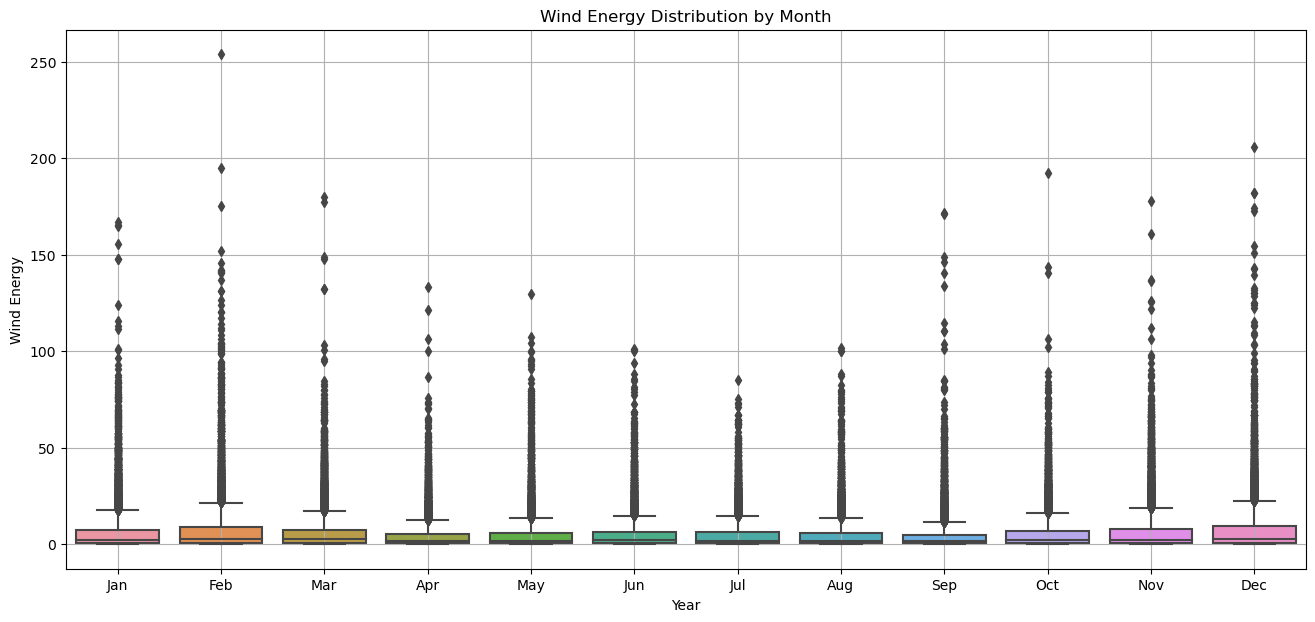

In [159]:
plt.figure(figsize=(16, 7))
sns.boxplot(x='month', y='windenergyMW', data=train_set)
plt.title('Wind Energy Distribution by Month')
plt.xlabel('Year')
plt.ylabel('Wind Energy')
plt.grid(True)
plt.show()

No clear trend shown in the box plot

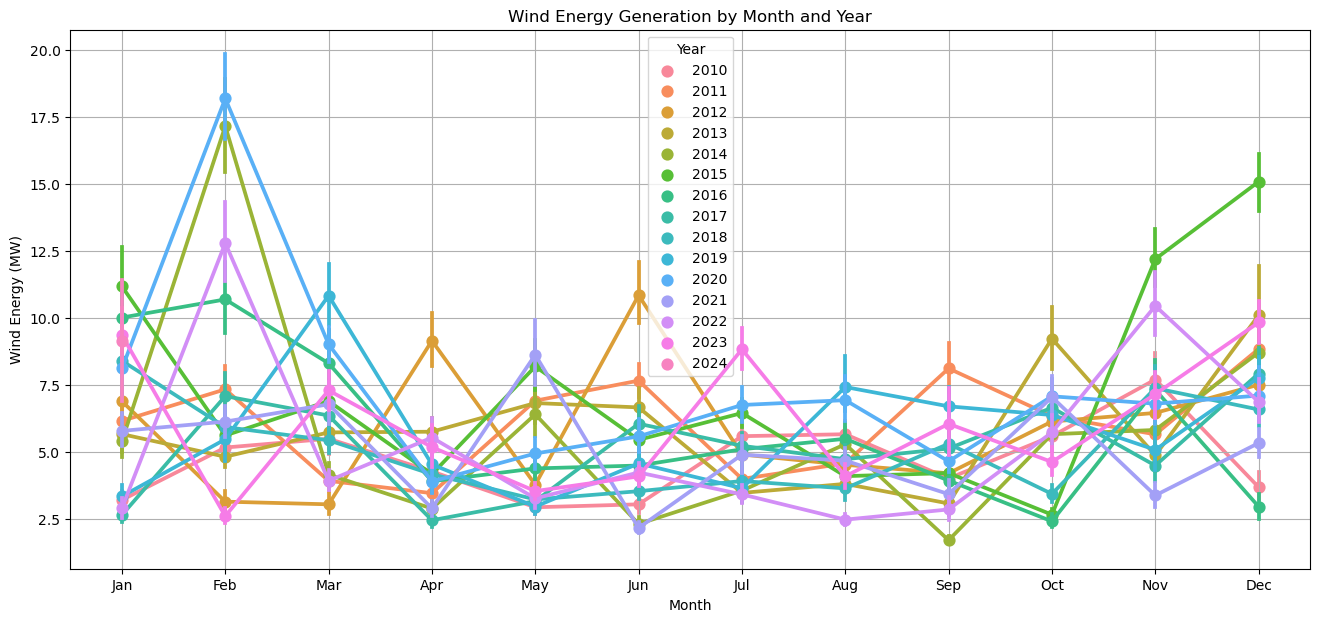

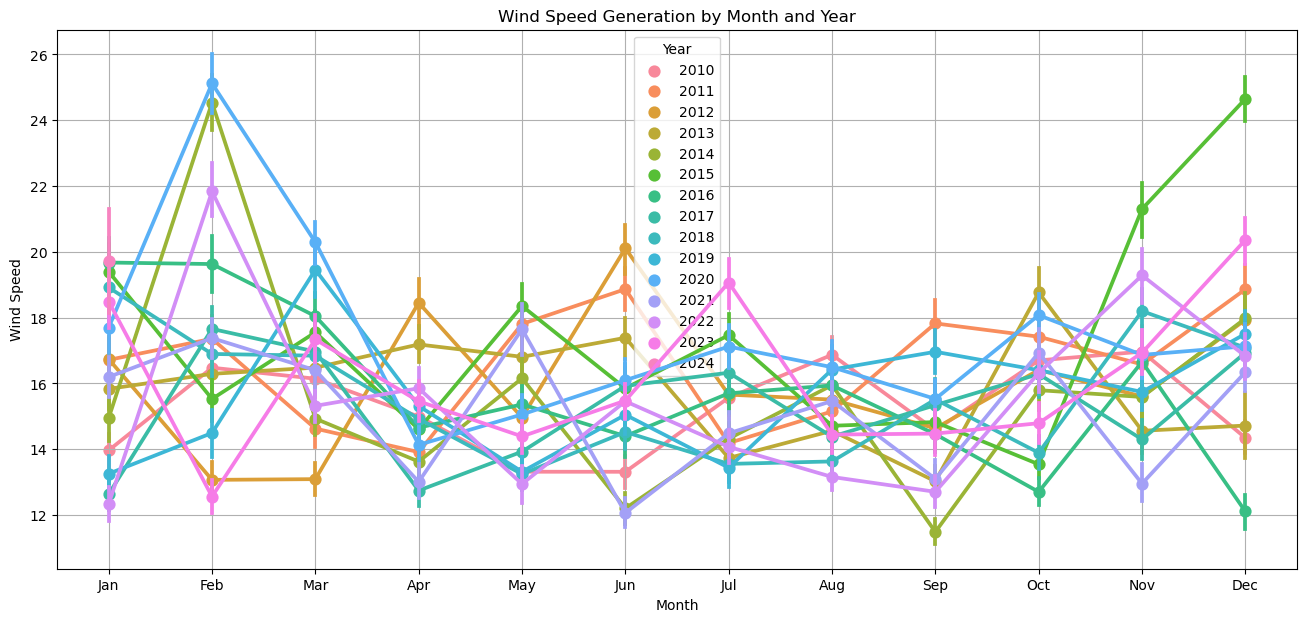

In [160]:
# Stacked line plot for wind energy
plt.figure(figsize=(16,7))
sns.pointplot(x='month', y='windenergyMW', hue='year', data=train_set)
plt.title('Wind Energy Generation by Month and Year')
plt.xlabel('Month')
plt.ylabel('Wind Energy (MW)')
plt.legend(title='Year')
plt.grid(True)
plt.show()

#Verifying with wind speed to check if the wind energy calculations is wrong
plt.figure(figsize=(16,7))
sns.pointplot(x='month', y='windspeed', hue='year', data=train_set)
plt.title('Wind Speed Generation by Month and Year')
plt.xlabel('Month')
plt.ylabel('Wind Speed')
plt.legend(title='Year')
plt.grid(True)
plt.show()

Wind Energy Seasonal Plot does not show us a clear seasonal trend.

# Decomposing our Timeseries

In [161]:
# Time series decomposition
# Let's downsample our timeseries first: average temperatures per month
data_ds = train_set['windenergyMW'].resample('M').mean().ffill().to_frame()  # one value per month
data_ds['solarenergyMW'] = train_set['solarenergyMW'].resample('M').mean().ffill()
data_ds

,windenergyMW,solarenergyMW
datetime,,
2010-01-31,3.204842,0.055287
2010-02-28,5.163006,0.093914
2010-03-31,5.490228,0.186344
2010-04-30,4.269681,0.333306
2010-05-31,2.932890,0.391895
...,...,...
2023-09-30,6.047125,0.205000
2023-10-31,4.623804,0.109933
2023-11-30,7.155944,0.049597


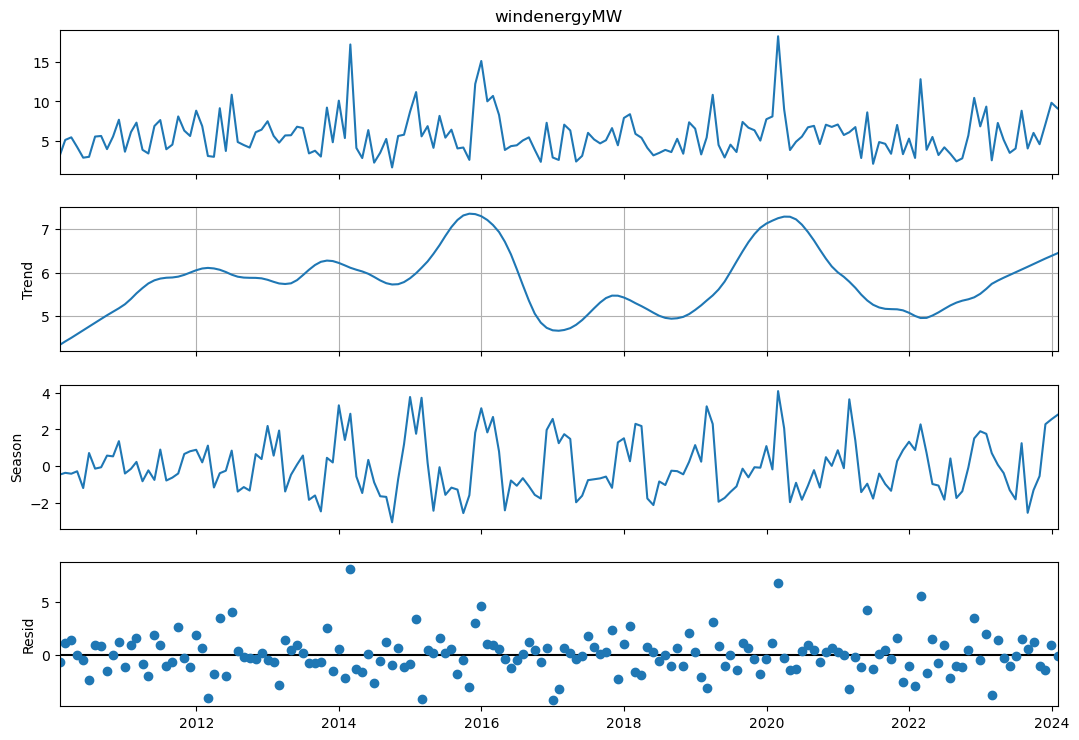

In [162]:
# Try decomposition on the resampled dataset
decomposition = STL(data_ds['windenergyMW']).fit()
fig = decomposition.plot()
fig.set_size_inches(12,8)
fig.axes[1].grid() # so we can check a bit better if there's a trend or not

- Top Panel (windenergyMW): The data is quite volatile with sharp peaks and troughs, suggesting significant short-term fluctuations.

- Second Panel (Trend): The extracted trend component shows an initial period of relative stability, followed by a gradual increase and then a decrease. Around 2016, there's a noticeable peak, suggesting that during this period, the average energy production was at its highest. The trend then decreases towards the end of the dataset, which might indicate less favorable wind conditions during that period. 

- Third Panel (Season): This reflects on the more unpredictable nature of wind patterns. There are still periodic elements that suggest seasonality in wind energy production, but the amplitude of these seasonal fluctuations is quite variable.

- Bottom Panel (Resid): The residuals, or the noise, in this model are much more pronounced.

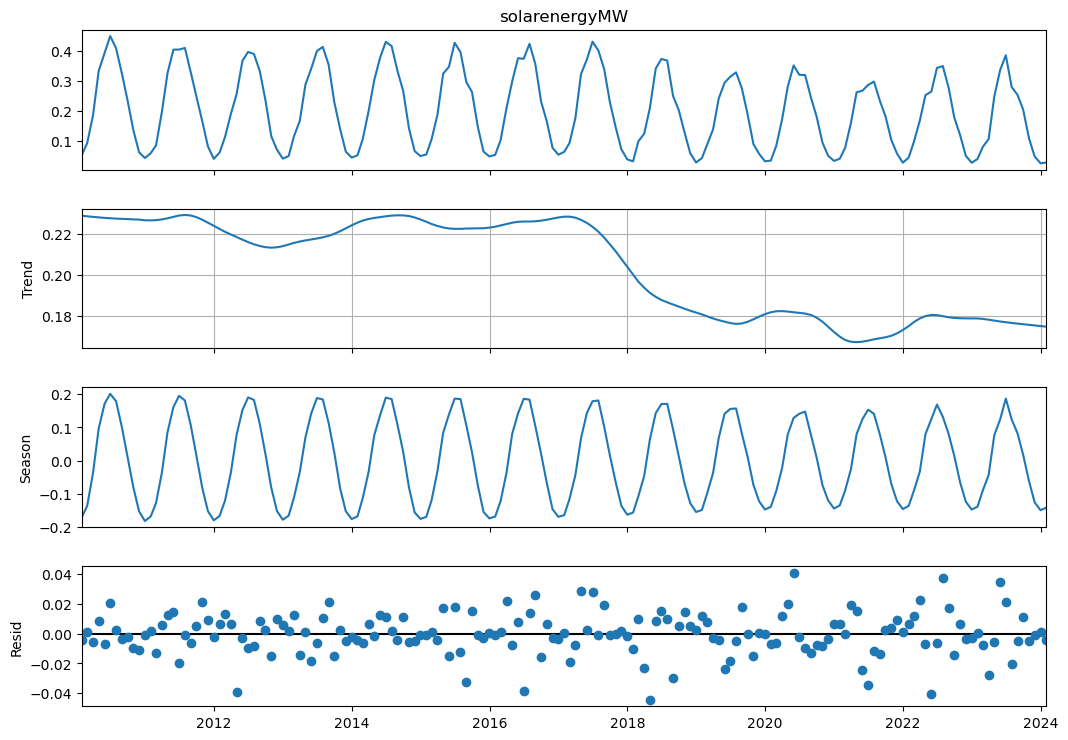

In [163]:
# Try decomposition on the resampled dataset
decomposition = STL(data_ds['solarenergyMW']).fit()
fig = decomposition.plot()
fig.set_size_inches(12,8)
fig.axes[1].grid() # so we can check a bit better if there's a trend or not

- Top Panel (solarenergyMW): This shows the original solar energy production data. The pattern is cyclical with regular oscillations, suggesting a strong seasonal influence, which is expected given that solar energy production is highly dependent on daylight hours and sun intensity, both of which are seasonally dependent.

- The seasonal component has a clear and consistent pattern that repeats annually. This reflects the predictable variation in solar energy production related to the seasons.
 
- Bottom Panel (Resid): The residuals here are quite tight around the zero line and do not show the same level of variability as the wind energy residuals. This suggests that the model for solar energy production is capturing the majority of the systematic variation in the data, leaving a small amount of noise that appears to be random and is likely due to short-term, unpredictable fluctuations in solar energy production.

In [164]:
# Statistical test for stationarity: Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(data_ds['windenergyMW'])
print('ADF Statistic %.2f:' % adf_result[0])
print('ADF p-value: %.4f:' % adf_result[1])
# p-value << 0.05 ==> timeseries does not have a unit root and maybe stationary 

ADF Statistic -11.10:
ADF p-value: 0.0000:


In [165]:
# Statistical test for stationarity: Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(data_ds['solarenergyMW'])
print('ADF Statistic %.2f:' % adf_result[0])
print('ADF p-value: %.4f:' % adf_result[1])
# p-value << 0.05 ==> timeseries does not have a unit root and maybe stationary

ADF Statistic -0.84:
ADF p-value: 0.8085:


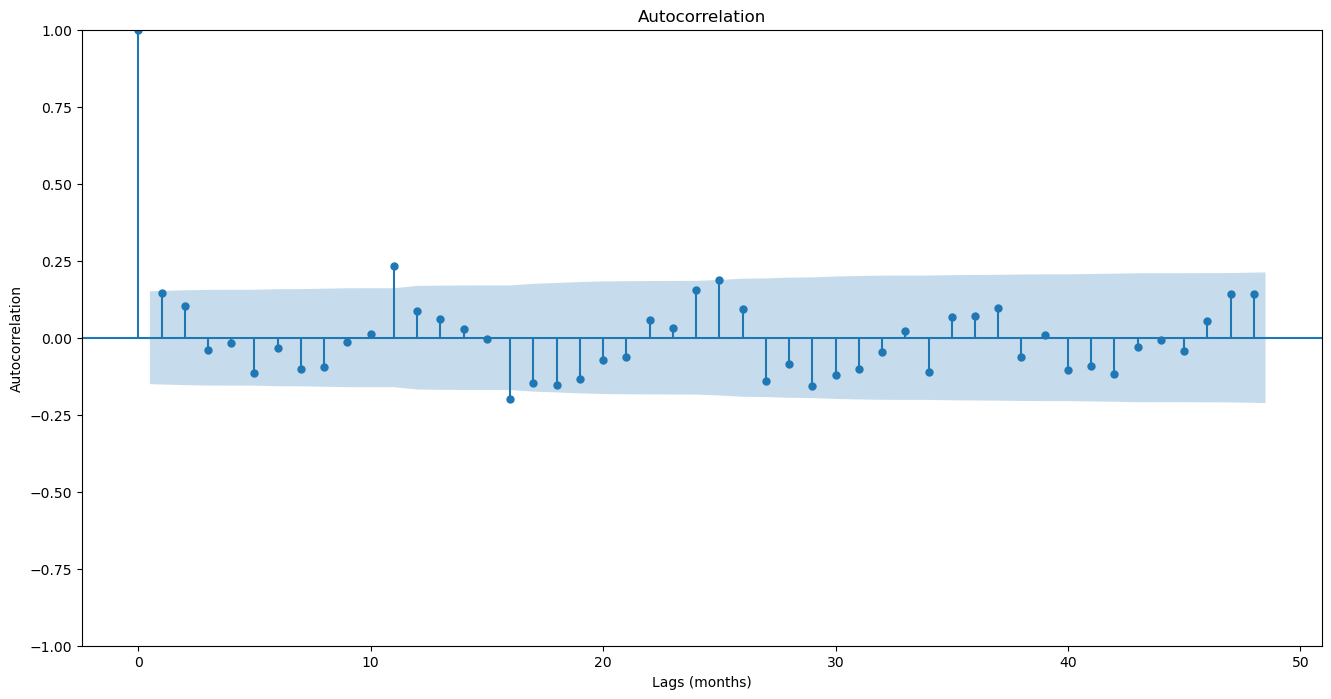

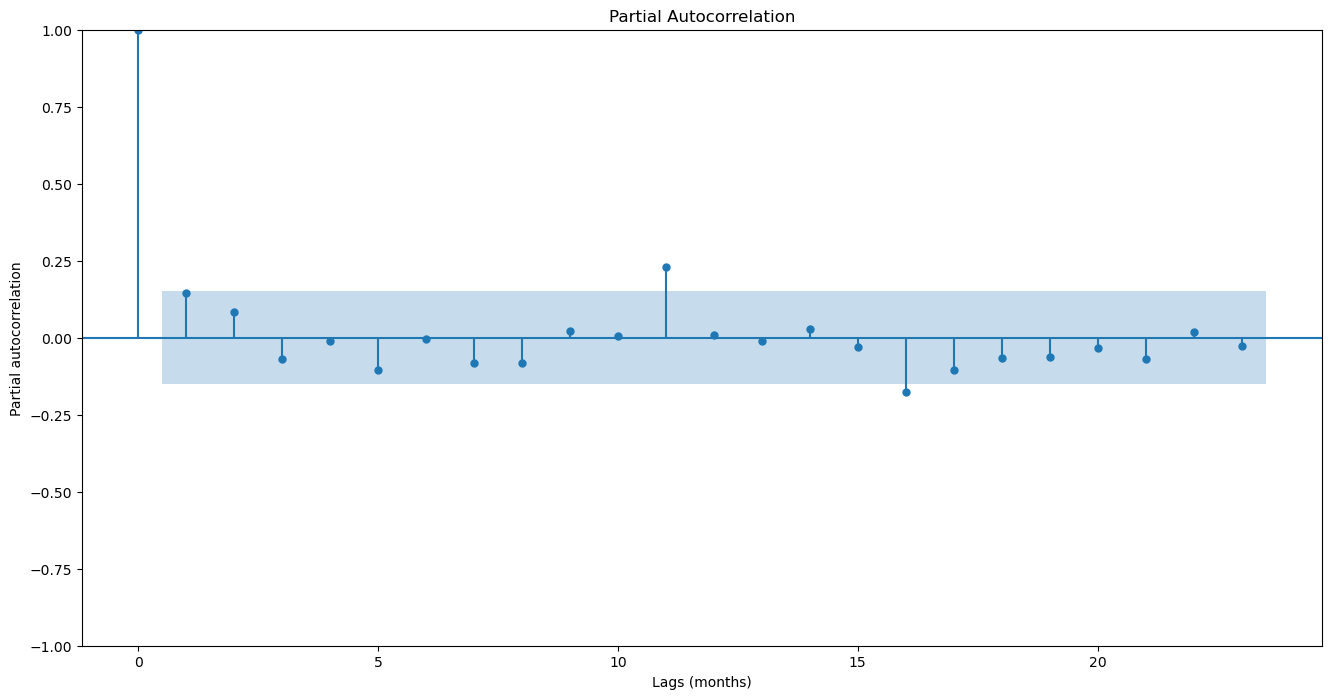

In [166]:
# Autocorrelation (can help us with modelling later)
fig, ax = plt.subplots(figsize=(16,8))
_=plot_acf(data_ds['windenergyMW'], lags=48, ax=ax)  # each lag is one month, so we're looking at 4 years worth of past data
_=plt.xlabel('Lags (months)')
_=plt.ylabel('Autocorrelation')


# Partial autocorrelation (can help us with modelling later)
fig, ax = plt.subplots(figsize=(16,8))
_=plot_pacf(data_ds['windenergyMW'], ax=ax)
_=plt.xlabel('Lags (months)')
_=plt.ylabel('Partial autocorrelation')

-  The autocorrelation function plot shows the correlation of the time series with its own lagged values. The ACF plot here displays significant autocorrelation at the first lag, and it diminishes as the lags increase, but it doesn't drop off immediately to zero, which usually indicates a non-stationary series.

- The partial autocorrelation function plot shows the correlation of the series with its own lagged values, but after eliminating the variations already explained by the intervening comparisons.The PACF plot exhibits a significant spike at the first lag and essentially drops to insignificant levels for subsequent lags. This pattern is typical for an AR(1) process. Will have to check on this a bit more while modelling.

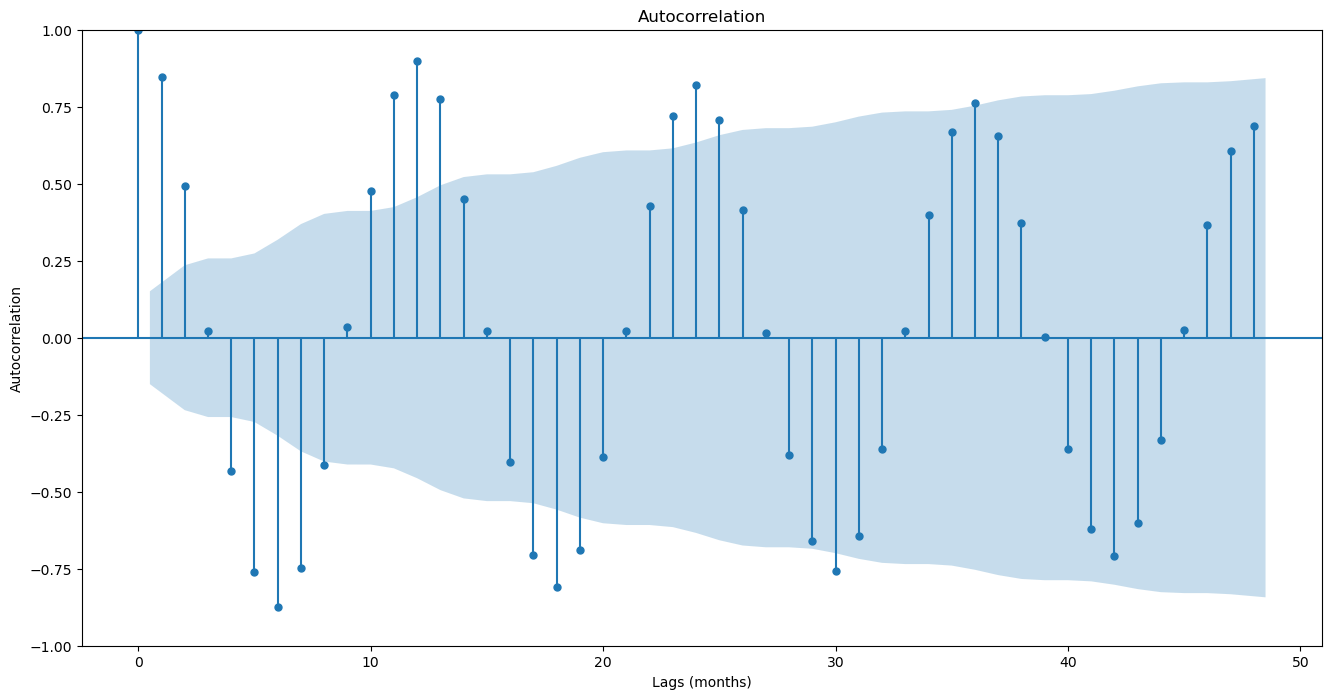

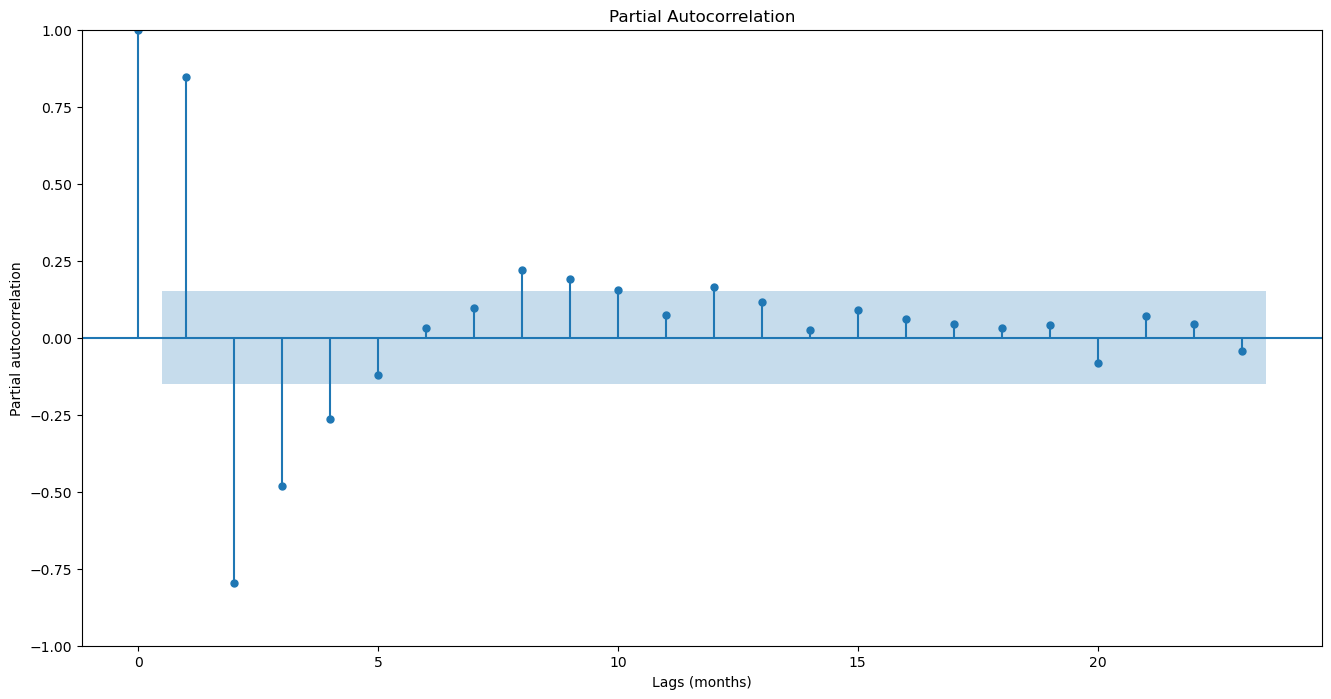

In [167]:
# Autocorrelation
fig, ax = plt.subplots(figsize=(16,8))
_=plot_acf(data_ds['solarenergyMW'], lags=48, ax=ax)  # each lag is one month, so we're looking at 4 years worth of past data
_=plt.xlabel('Lags (months)')
_=plt.ylabel('Autocorrelation')


# Partial autocorrelation 
fig, ax = plt.subplots(figsize=(16,8))
_=plot_pacf(data_ds['solarenergyMW'], ax=ax)
_=plt.xlabel('Lags (months)')
_=plt.ylabel('Partial autocorrelation')

df = train_set

- The ACF plot exhibits strong sinusoidal patterns, indicating strong seasonality, and the PACF plot shows a significant spike at lag 1, which decays more quickly but still with some sinusoidal pattern. This suggests that the series is not stationary and has a strong seasonal component.

In [168]:
df.head()

,temp,dew,humidity,precip,precipprob,snow,snowdepth,windspeed,winddir,sealevelpressure,...,solarradiation,uvindex,year,windspeed_ms,windenergyMW,solarenergyMW,datetime_copy,month,windenergyMW_future_24h,solarenergyMW_future_24h
datetime,,,,,,,,,,,,,,,,,,,,,
2010-01-03 00:00:00,0.5,-0.5,92.97,0.0,0.0,0.0,0.0,5.8,284.0,1019.6,...,0.0,0.0,2010,1.611112,0.14,0.0,2010-01-03 00:00:00,Jan,0.02,0.0
2010-01-03 01:00:00,0.0,-1.1,91.98,0.0,0.0,0.0,0.0,9.6,334.0,1019.5,...,0.0,0.0,2010,2.666669,0.61,0.0,2010-01-03 01:00:00,Jan,0.14,0.0
2010-01-03 02:00:00,-0.6,-1.4,94.85,0.0,0.0,0.0,0.0,4.4,320.0,1020.0,...,0.0,0.0,2010,1.222223,0.06,0.0,2010-01-03 02:00:00,Jan,0.08,0.0
2010-01-03 03:00:00,-1.3,-1.8,96.09,0.0,0.0,0.0,0.0,2.5,322.0,1020.5,...,0.0,0.0,2010,0.694445,0.01,0.0,2010-01-03 03:00:00,Jan,0.08,0.0
2010-01-03 04:00:00,-0.1,-0.4,97.51,0.0,0.0,0.0,0.0,5.6,360.0,1020.8,...,0.0,0.0,2010,1.555557,0.12,0.0,2010-01-03 04:00:00,Jan,0.04,0.0


# Exporting the Final Dataset



In [169]:
# Export the DataFrame to a CSV file
df.to_csv('dataset.csv', index=False)

print("DataFrame exported to dataset.csv")


DataFrame exported to dataset.csv
